In [2]:
# Initialization
# Reset all variables in the current Jupyter Notebook environment

%reset -f

In [4]:
#Import libraries

import math as math
import cmath as cmath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.optimize import fsolve
from scipy.integrate import quad
from sklearn.linear_model import LinearRegression

In [7]:
# Question 1
# a) Heston Model

# Parameters

S0 = 100
x0 = math.log(S0)
r = 0.05
y = 0.02
v0 = 0.25
kappa = 0.2
theta = 0.2
lamda = 1
sigma = 0.3
rho = -0.2
T = 21/252
a = kappa * theta
u = [0.5, -0.5]
b = [kappa + lamda - rho * sigma, kappa + lamda]
strikes = [95, 100, 105]
df = np.exp(-(r - y) * T) # the discounted factor

In [9]:
# Compute the characteristic functions for the Heston model
def characteristic_func(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b, phi):

    d = [0.0, 0.0]
    g = [0.0, 0.0]
    C = [0.0, 0.0]
    D = [0.0, 0.0]
    edt = [0.0, 0.0]
    gedt = [0.0, 0.0]
    f = [0.0, 0.0]

    for j in range(2):
        temp = b[j] - 1j * rho * sigma * phi
        d[j] = cmath.sqrt(temp**2 - sigma**2 * (2.0 * u[j] * phi * 1j - phi**2))
        g[j] = (temp + d[j]) / (temp - d[j])

        edt[j] = cmath.exp(d[j] * T)
        gedt[j] = 1.0 - g[j] * edt[j]

        C[j] = (r - y) * phi * T * 1j + a / sigma**2 * ((temp + d[j]) * T - 2.0 * cmath.log(gedt[j] / (1.0 - g[j])))
        D[j] = (temp + d[j]) * (1.0 - edt[j]) / gedt[j] / sigma**2

        f[j] = cmath.exp(C[j] + D[j] * v0 + 1j * phi * x0)

    return f

In [11]:
# Compute probabilities P1 and P2 for the Heston model.
def probabilities(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b):

    ln_k = math.log(K)  # Compute the log of the strike price

    # Compute the integrand for P1 and P2
    def integrand(phi, index):
        f = characteristic_func(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b, phi)
        if index == 0:  # For P1
            temp = cmath.exp(-1j * phi * ln_k) * f[0] / (1j * phi)
        else:  # For P2
            temp = cmath.exp(-1j * phi * ln_k) * f[1] / (1j * phi)
        return temp.real

    # Use quad to compute the integrals
    pi_i = 1.0 / math.pi
    P1_integral, _ = quad(lambda phi: integrand(phi, 0), 0, math.inf)  # P1 integral
    P2_integral, _ = quad(lambda phi: integrand(phi, 1), 0, math.inf)  # P2 integral

    P1 = 0.5 + pi_i * P1_integral
    P2 = 0.5 + pi_i * P2_integral
    return [P1, P2]

In [13]:
# Compute the call price using probabilities from the Heston model
def call_price(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b):
    P = probabilities(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b)
    call_price = math.exp(-y * T) * S0 * P[0] - math.exp(-r * T) * K * P[1]
    return call_price

In [15]:
# Compute call prices for each strike
call_prices = [call_price(S0, x0, K, r, y, v0, kappa, theta, lamda, sigma, rho, T, a, u, b) for K in strikes]

# Display the results
table_heston = pd.DataFrame({"Strike Price (K)": strikes, "European Call Price": call_prices})
table_heston

,Strike Price (K),European Call Price
0,95,8.488870
1,100,5.731202
2,105,3.671103


In [17]:
# b) Monte Carlo Simulation

# Parameters
H = 90  # Barrier level
n_paths = 100000  # Number of Monte Carlo paths
n_steps = int(T * 252)  # Number of time steps
dt = 1 / 252  # Time step

In [19]:
# Seed for reproducibility
np.random.seed(42)

# Simulate Heston dynamics
def simulate_heston(S0, v0, kappa, theta, sigma, rho, r, y, T, n_paths, n_steps, dt, H):
    S = np.zeros((n_paths, n_steps + 1))  # Stock prices
    v = np.zeros((n_paths, n_steps + 1))  # Variances
    S[:, 0] = S0
    v[:, 0] = v0
    barrier_breached = np.zeros(n_paths, dtype=bool)  # Track barrier breach

    # Generate correlated Brownian motions
    Z1 = np.random.normal(size=(n_paths, n_steps))
    Z2 = np.random.normal(size=(n_paths, n_steps))
    W1 = Z1
    W2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2

    for t in range(1, n_steps + 1):
        v[:, t] = np.maximum((v[:, t - 1] + kappa * (theta - v[:, t - 1]) * dt +
                                sigma * np.sqrt(v[:, t - 1] * dt) * W2[:, t - 1]),0)
        S[:, t] = S[:, t - 1] * np.exp((r - y - 0.5 * v[:, t - 1]) * dt +
                                np.sqrt(v[:, t - 1] * dt) * W1[:, t - 1])
        barrier_breached = barrier_breached | (S[:, t] <= H)
    return S, barrier_breached

# Monte Carlo pricing of down-and-out call options
def monte_carlo_down_and_out(S0, v0, kappa, theta, sigma, rho, r, y, T, strikes, n_paths, n_steps, dt, H):
    S, barrier_breached = simulate_heston(S0, v0, kappa, theta, sigma, rho, r, y, T, n_paths, n_steps, dt, H)
    call_prices = []
    S_T = S[:, -1]  # Terminal stock prices

    for K in strikes:
        payoffs = np.where(~barrier_breached, np.maximum(S_T - K, 0), 0)
        price = df * np.mean(payoffs)
        variance = np.var(payoffs)  # Calculate variance of payoffs
        call_prices.append((price, variance))

    return call_prices

# Compute prices for given strikes
down_and_out_prices = monte_carlo_down_and_out(S0, v0, kappa, theta, sigma, rho, r, y, T, strikes, n_paths, n_steps, dt, H)

price = [item[0] for item in down_and_out_prices]
variance = [item[1] for item in down_and_out_prices]

# Display the results
table_mc = pd.DataFrame({"Strike Price (K)": strikes, "Down-and-Out Call Price": price, "Variance": variance})
table_mc

,Strike Price (K),Down-and-Out Call Price,Variance
0,95,8.002482,118.213744
1,100,5.573128,83.704861
2,105,3.659962,55.631775


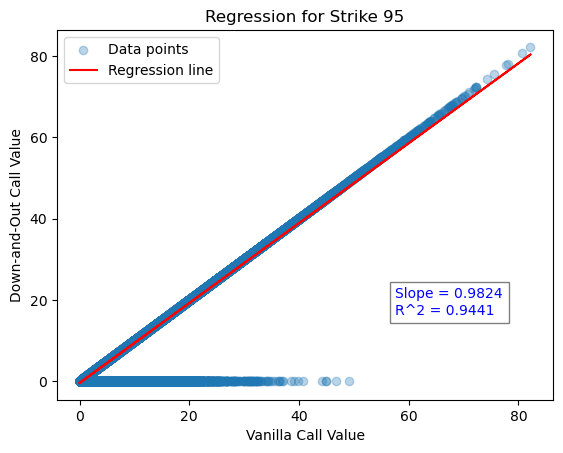

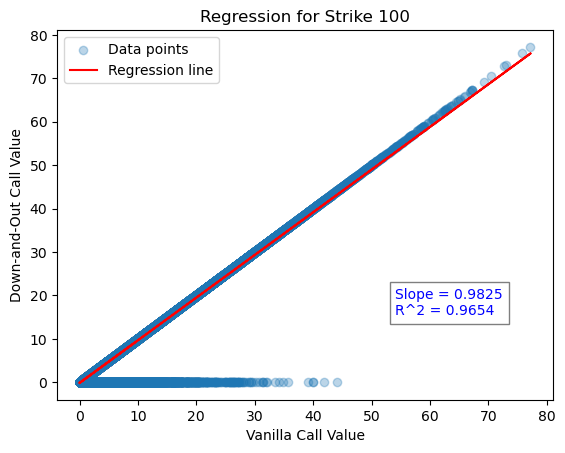

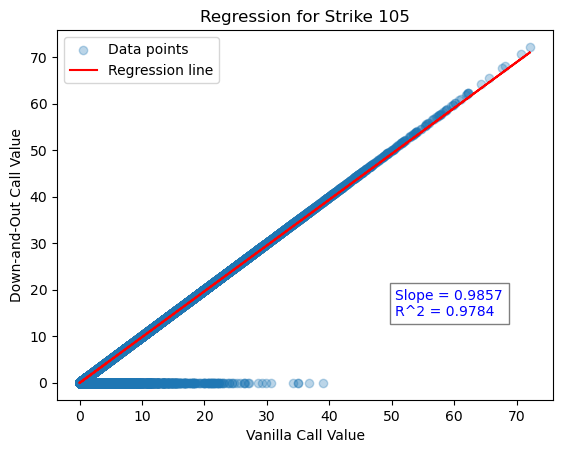

,Strike Price (K),Adjusted Down-and-Out Call Price,Adjusted Variance,Slope,R^2
0,95,8.023888,6.593131,0.982377,0.944124
1,100,5.592193,2.895549,0.982453,0.965360
2,105,3.676049,1.200898,0.985728,0.978392


In [21]:
# c) Control Variate Method

# Vanilla European call pricing using Monte Carlo
def monte_carlo_vanilla_call(S, K, r, T):
    S_T = S[:, -1]  # Terminal stock prices
    payoffs = np.maximum(S_T - K, 0)
    return df * payoffs

# Monte Carlo refinement with control variates
def control_variate_refinement(S0, v0, kappa, theta, sigma, rho, r, y, T, strikes, n_paths, n_steps, dt, H, n_batches):
    # Split paths into batches
    batch_size = n_paths // n_batches
    S, barrier_breached = simulate_heston(S0, v0, kappa, theta, sigma, rho, r, y, T, n_paths, n_steps, dt, H)

    # Store regression results
    adjusted_prices = []
    variances = []
    slopes = []
    r_squared = []
    
    # For each strike
    for K in strikes:
        down_and_out_values = []
        vanilla_call_values = []

        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size

            # Batch data
            S_batch = S[start_idx:end_idx]
            barrier_breached_batch = barrier_breached[start_idx:end_idx]

            # Down-and-out payoffs
            down_and_out_payoffs = np.where(~barrier_breached_batch, np.maximum(S_batch[:, -1] - K, 0), 0)
            down_and_out_values.append(df * down_and_out_payoffs)

            # Vanilla call payoffs
            vanilla_call_payoffs = monte_carlo_vanilla_call(S_batch, K, r, T)
            vanilla_call_values.append(vanilla_call_payoffs)

        # Combine all batches
        down_and_out_values = np.concatenate(down_and_out_values)
        vanilla_call_values = np.concatenate(vanilla_call_values)

        # Perform regression
        reg = LinearRegression()
        X = vanilla_call_values.reshape(-1, 1)
        Y = down_and_out_values
        reg.fit(X, Y)
        beta = reg.coef_[0]
        r2 = reg.score(X, Y)

        slopes.append(beta)
        r_squared.append(r2)
        
        adjusted_payoffs = Y - beta * (X.flatten() - np.mean(X))

        # Calculate adjusted price and variance
        adjusted_price = np.mean(adjusted_payoffs)
        variance = np.var(adjusted_payoffs)
        adjusted_prices.append(adjusted_price)
        variances.append(variance)

        # Plot data and regression line
        plt.scatter(X, Y, alpha=0.3, label="Data points")
        plt.plot(X, reg.predict(X), color='red', label="Regression line")
        plt.xlabel("Vanilla Call Value")
        plt.ylabel("Down-and-Out Call Value")
        plt.title(f"Regression for Strike {K}")
        plt.text(0.7 * max(X), 0.2 * max(Y),   
                 f"Slope = {beta:.4f}\nR^2 = {r2:.4f}", 
                 color="blue", fontsize=10,
                 bbox=dict(facecolor='white', alpha=0.5),
                 ha='left') 
        plt.legend()
        plt.show()

    return adjusted_prices, variances, slopes, r_squared

# Run control variate refinement
control_variate = control_variate_refinement(S0, v0, kappa, theta, sigma, rho, r, y, T, strikes, n_paths, n_steps, dt, H, n_batches=40)

price = control_variate[0]
variance = control_variate[1]
slope = control_variate[2]
r2 = control_variate[3]

# Display the results
table_cv = pd.DataFrame({"Strike Price (K)": strikes, "Adjusted Down-and-Out Call Price": price, 
                      "Adjusted Variance": variance, "Slope":slope, "R^2":r2})
table_cv

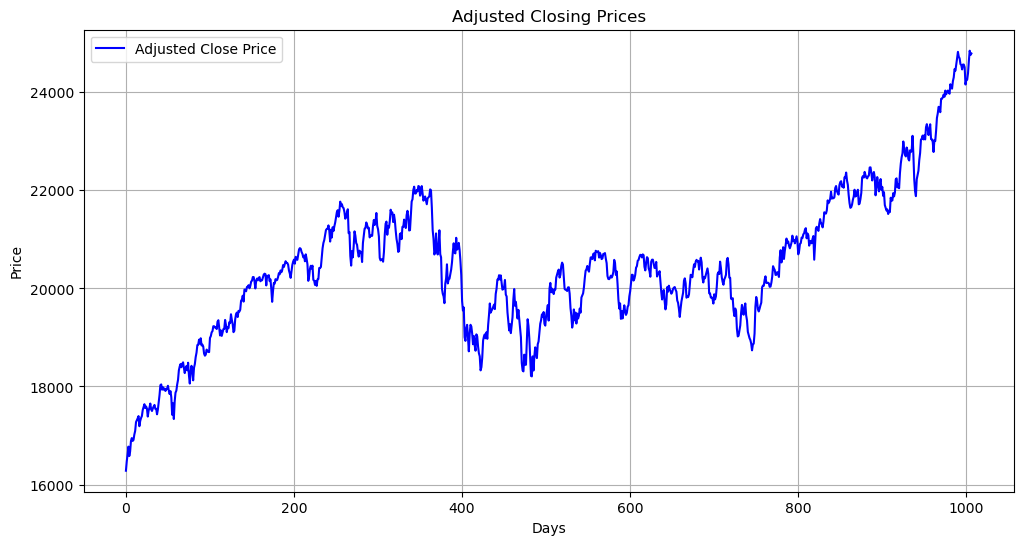

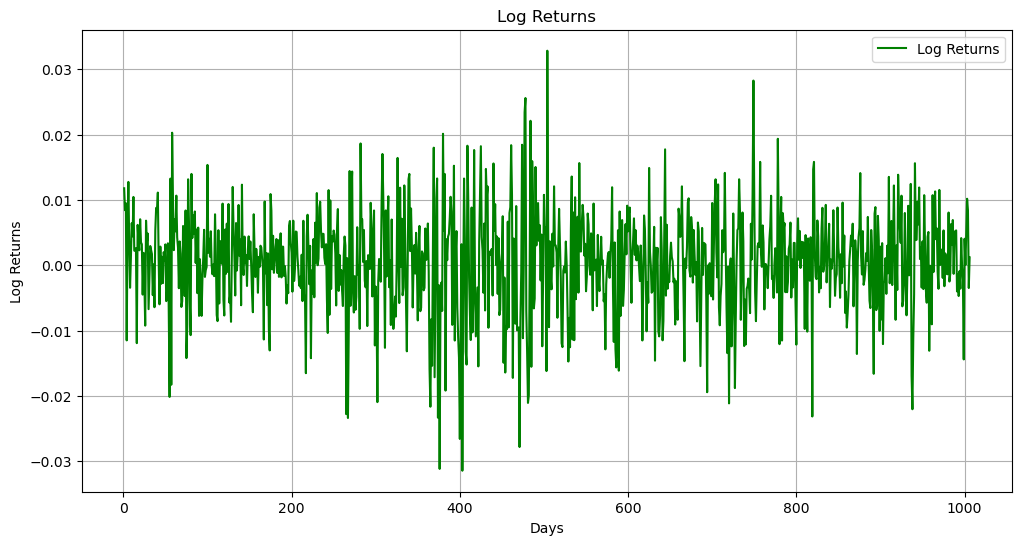

Sample Annualized Return Volatility: 12.37%


In [6]:
# Question 2
# a)

# Load data
file_path = "dataTP2_A2024.csv"  # Update this to the correct file path
data = pd.read_csv(file_path, header=None, names=['Price'])  # Add column name for clarity
prices = data['Price']

# Compute log daily returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Plot adjusted closing prices
plt.figure(figsize=(12, 6))
plt.plot(prices, label='Adjusted Close Price', color='blue')
plt.title('Adjusted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Plot log daily returns
plt.figure(figsize=(12, 6))
plt.plot(log_returns, label='Log Returns', color='green')
plt.title('Log Returns')
plt.xlabel('Days')
plt.ylabel('Log Returns')
plt.legend()
plt.grid()
plt.show()

# Compute sample return volatility
sample_volatility = log_returns.std()
annualized_volatility = sample_volatility * np.sqrt(252)
print(f"Sample Annualized Return Volatility: {annualized_volatility:.2%}")

In [8]:
# b) NGARCH Model

# Parameters
daily_rf_rate = 0.0275 / 365  # Daily risk-free rate
initial_variance = log_returns.iloc[0] ** 2  # Initialize h_0 with the square of the first return

# NGARCH(1,1) log-likelihood function
def ngarch_log_likelihood(params, returns):
    omega, alpha, beta, gamma, lam = params

    # Initialize variance and arrays
    n = len(returns)
    h = np.zeros(n)
    h[0] = initial_variance
    z = np.zeros(n)

    log_likelihood = 0

    # Recursively compute variances and residuals
    epsilon = 1e-8  # Small value to prevent division by zero
    for t in range(1, n):
        # Update variance
        h[t] = omega + alpha * h[t - 1] * (z[t - 1] - gamma) ** 2 + beta * h[t - 1]
        if h[t] < 1e-8:  # Prevent non-positive variance
            h[t] = 1e-8
        elif h[t] > 1e6:  # Cap excessively large variances
            h[t] = 1e6

        # Update standardized residuals
        z[t] = (returns[t] - daily_rf_rate - lam * np.sqrt(h[t]) + 0.5 * h[t]) / (np.sqrt(h[t]) + epsilon)

        # Increment log-likelihood
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(h[t]) + z[t] ** 2)

    return -log_likelihood  # Negative for minimization


# Initial parameter guesses
initial_guess = [0.0, 0.01, 0.75, 0.0, 0.05]  # [omega, alpha, beta, gamma, lambda]
bounds = [
    (1e-6, 1),  # omega > 0 and reasonably small
    (1e-6, 0.5),  # 0 < alpha < 0.5
    (1e-6, 0.9),  # 0 < beta < 0.9 (stationarity requires alpha + beta < 1)
    (-1, 1),  # -1 < gamma < 1
    (-5, 5),  # Reasonable bounds for lambda
]


# Optimization
result = minimize(
    ngarch_log_likelihood,
    initial_guess,
    args=(log_returns.values,),
    bounds=bounds,
    method="L-BFGS-B"
)

# Extract estimated parameters
omega, alpha, beta, gamma, lam = result.x

# Compute implied unconditional volatility
unconditional_variance = omega / (1 - alpha * (1 + gamma ** 2) - beta)
unconditional_volatility = np.sqrt(unconditional_variance)

# Compare to sample volatility
sample_volatility = log_returns.std()


# Display the results
table_para = pd.DataFrame({'omega': [omega], 
                           'alpha': [alpha], 
                           'beta': [beta], 
                           'gamma': [gamma], 
                           'lambda': [lam]})
print("Estimated Parameters")
table_para

Estimated Parameters


,omega,alpha,beta,gamma,lambda
0,0.000014,0.010006,0.750001,0.000013,0.050064


In [10]:
# Display the results for comparing volatilities
table_vol = pd.DataFrame({'Unconditional Volatility':[unconditional_volatility],
                          'Sample Volatility':[sample_volatility]})
table_vol

,Unconditional Volatility,Sample Volatility
0,0.00765,0.007793


In [12]:
# c) Monte Carlo Simulation

# Given parameters:
num_paths = 100000
num_days = 63
strikes = np.arange(23000, 28001, 100)  # Strike prices from 23,000 to 28,000
S_0 = data.iloc[-1, 0]  # Set observed adjusted close as S_0
daily_rf_rate = 0.0275 / 365  # Daily risk-free rate (2.75% annualized)
initial_variance = log_returns.iloc[0] ** 2  # Initial guess for variance (adjust as necessary)

# Calculate gamma* = gamma + lambda
gamma_star = gamma + lam

# Initialize arrays for simulation
simulated_prices = np.zeros((num_paths, num_days))
simulated_prices[:, 0] = S_0  # Start from the initial spot price

# Simulate paths
h_sim = np.full(num_paths, initial_variance)  # Initialize variance for all paths
z_sim = np.zeros(num_paths)  # Residuals for all paths
epsilon_star_sim = np.zeros(num_paths)  # Residuals for epsilon_star

# Simulate 100,000 paths over 63 days
for t in range(1, num_days):
    # Simulate shocks (epsilon_star_t under Q-measure)
    epsilon_star_sim = np.random.normal(0, 1, num_paths)

    # Update variance using NGARCH(1,1) model under Q-measure
    h_sim = omega + alpha * h_sim * (epsilon_star_sim - gamma_star * np.sqrt(h_sim))**2 + beta * h_sim
    h_sim = np.maximum(h_sim, 1e-8)  # Prevent non-positive variance

    # Update returns using Q-measure dynamics
    r_sim = daily_rf_rate - 0.5 * h_sim + np.sqrt(h_sim) * epsilon_star_sim

    # Update prices using the Q-measure return process
    simulated_prices[:, t] = simulated_prices[:, t-1] * np.exp(r_sim)

# Evaluate European Call Options at t = 0
discount_factor = np.exp(-daily_rf_rate * num_days)
call_prices_at_t0 = []

# Calculate call prices at t=0
for K in strikes:
    # Compute payoffs for all paths at t = T (at maturity)
    payoffs = np.maximum(simulated_prices[:, -1] - K, 0)

    # Discount and average to get option price at t = 0
    call_price_at_t0 = discount_factor * np.mean(payoffs)
    call_prices_at_t0.append(call_price_at_t0)

# Display the results
table_call_prices = pd.DataFrame({'Strike Price': strikes,'European Call Price': call_prices_at_t0})
table_call_prices

,Strike Price,European Call Price
0,23000,1968.493362
1,23100,1880.332794
2,23200,1793.533546
3,23300,1708.210604
4,23400,1624.410774
5,23500,1542.292899
6,23600,1461.994494
7,23700,1383.638419
8,23800,1307.294437
9,23900,1233.110240


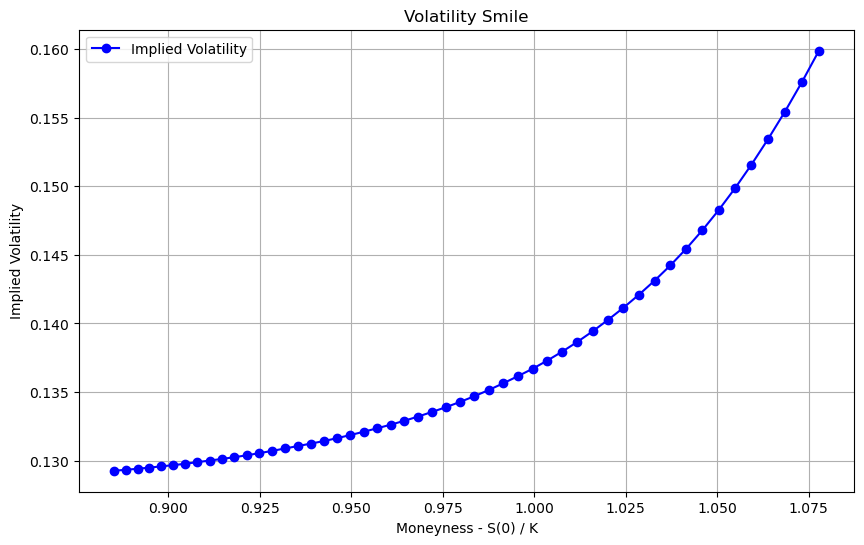

In [14]:
# d) Volatility Smile

# Calculate moneyness S_0 / K for each strike price
moneyness = S_0 / strikes

# Black-Scholes formula to calculate the European call option price
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    
# Function to calculate implied volatility using fsolve
def implied_volatility_call(S, K, T, r, market_price):
    # Objective function to minimize (difference between market price and Black-Scholes price)
    objective = lambda sigma: black_scholes_call(S, K, T, r, sigma) - market_price
    # Use fsolve to find the implied volatility
    implied_vol = fsolve(objective, 0.2)[0]  # Initial guess is 0.2
    return implied_vol

# Calculate implied volatility for each strike using fsolve
implied_vols = []
for i in range(len(strikes)):
    K = strikes[i]
    market_price = call_prices_at_t0[i]

    # Calculate implied volatility
    implied_vol = implied_volatility_call(S_0, K, num_days / 252, daily_rf_rate, market_price)
    implied_vols.append(implied_vol)

# Plot the volatility smile based on moneyness
plt.figure(figsize=(10, 6))
plt.plot(moneyness, implied_vols, marker='o', color='blue', linestyle='-', label="Implied Volatility")

# Add labels and title
plt.title("Volatility Smile")
plt.xlabel("Moneyness - S(0) / K")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [16]:
# Appendix
# MC Simulations using BS formula

# Parameters
spot_price = 24789.28  # S_0, the spot price of the index
risk_free_rate_annual = 2.75 / 100  # 2.75% annual risk-free rate
expiry_days = 63  # Days to expiry
daily_rf_rate = risk_free_rate_annual / 365  # Convert to daily risk-free rate
sample_volatility = log_returns.std()  # Sample volatility
annualized_volatility = sample_volatility * np.sqrt(252)  # Annualized volatility

# Strike prices (from 23,000 to 28,000 with increments of 100)
strikes = np.arange(23000, 28001, 100)

# Time to maturity in years (63 days)
T = expiry_days / 252

# Calculate call prices for each strike
call_prices = []
for K in strikes:
    call_price = black_scholes_call(S_0, K, T, daily_rf_rate, annualized_volatility)
    call_prices.append(call_price)

# Store the results in a DataFrame
options_df = pd.DataFrame({
    'Strike': strikes,
    'Option Price': call_prices
})

print(options_df)

    Strike  Option Price
0    23000   1870.625860
1    23100   1783.234273
2    23200   1697.349919
3    23300   1613.083259
4    23400   1530.543942
5    23500   1449.839701
6    23600   1371.075236
7    23700   1294.351086
8    23800   1219.762530
9    23900   1147.398523
10   24000   1077.340694
11   24100   1009.662428
12   24200    944.428045
13   24300    881.692090
14   24400    821.498753
15   24500    763.881426
16   24600    708.862400
17   24700    656.452713
18   24800    606.652145
19   24900    559.449352
20   25000    514.822150
21   25100    472.737916
22   25200    433.154119
23   25300    396.018953
24   25400    361.272059
25   25500    328.845329
26   25600    298.663761
27   25700    270.646366
28   25800    244.707089
29   25900    220.755752
30   26000    198.698981
31   26100    178.441116
32   26200    159.885092
33   26300    142.933271
34   26400    127.488224
35   26500    113.453448
36   26600    100.734022
37   26700     89.237187
38   26800     78.872857


In [18]:
# Comparison
# Convert lists to NumPy arrays
call_prices_at_t0 = np.array(call_prices_at_t0)
call_prices = np.array(call_prices)

# Perform element-wise subtraction
diff = call_prices_at_t0 - call_prices

# Create the DataFrame
table_comparison = pd.DataFrame({
    'Strike': strikes,
    'NGARCH Price': call_prices_at_t0,
    'BS Price': call_prices,
    'Difference': diff
})

print(table_comparison)

    Strike  NGARCH Price     BS Price  Difference
0    23000   1968.493362  1870.625860   97.867502
1    23100   1880.332794  1783.234273   97.098521
2    23200   1793.533546  1697.349919   96.183627
3    23300   1708.210604  1613.083259   95.127345
4    23400   1624.410774  1530.543942   93.866832
5    23500   1542.292899  1449.839701   92.453198
6    23600   1461.994494  1371.075236   90.919258
7    23700   1383.638419  1294.351086   89.287333
8    23800   1307.294437  1219.762530   87.531907
9    23900   1233.110240  1147.398523   85.711718
10   24000   1161.153806  1077.340694   83.813112
11   24100   1091.454367  1009.662428   81.791939
12   24200   1024.040643   944.428045   79.612598
13   24300    958.994834   881.692090   77.302744
14   24400    896.317598   821.498753   74.818845
15   24500    836.133152   763.881426   72.251727
16   24600    778.488833   708.862400   69.626434
17   24700    723.384740   656.452713   66.932027
18   24800    670.844997   606.652145   64.192853
